In [162]:
import pandas as pd
import numpy as np

import io
from google.colab import files

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn import metrics

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, AveragePooling2D

# Feature selection

In [2]:
set_num = 1
set_type = 'train'

In [3]:
uploaded = files.upload()
globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"] = pd.read_csv(f"{set_type}_FD00{set_num}.txt", sep = ' ', header = None)

Saving train_FD001.txt to train_FD001.txt


In [4]:
globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"].drop([26,27], axis=1, inplace=True)
col_names = ['Engine_ID', 'NumCycle', 'OpSet1', 'OpSet2', 'OpSet3', 'Sensor1', 'Sensor2', 'Sensor3', 'Sensor4', 'Sensor5', 'Sensor6', 'Sensor7', 'Sensor8', 'Sensor9', 'Sensor10', 'Sensor11', 'Sensor12', 'Sensor13', 'Sensor14', 'Sensor15', 'Sensor16', 'Sensor17', 'Sensor18', 'Sensor19', 'Sensor20', 'Sensor21' ]
globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"].columns = col_names

In [5]:
#Append a 'Useful Life End' (ULE) in cycles to the dataset
ULE = []
for engine_num in globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]['Engine_ID']:
  ULE.append(len(globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"][globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]['Engine_ID'] == engine_num]))
globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]['ULE'] = ULE

# Append the 'Useful Life Remaining' (ULR) column to the dataset
globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]['ULR'] = globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]['ULE'] - (globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]['NumCycle'])

# Drop the Useful Life End columns
globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"].drop(['ULE'], axis=1, inplace=True)

globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]

,Engine_ID,NumCycle,OpSet1,OpSet2,OpSet3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,ULR
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


In [6]:
df = globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]
full_set_df = df.drop('Engine_ID', axis=1)
full_set_df.describe()

,NumCycle,OpSet1,OpSet2,OpSet3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor6,...,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,ULR
count,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,...,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000
mean,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,21.609803,...,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,107.807862
std,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,0.001389,...,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251,68.880990
min,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,...,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,0.000000
25%,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,21.610000,...,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,51.000000
50%,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,21.610000,...,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,103.000000
75%,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,21.610000,...,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,155.000000
max,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,...,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,361.000000


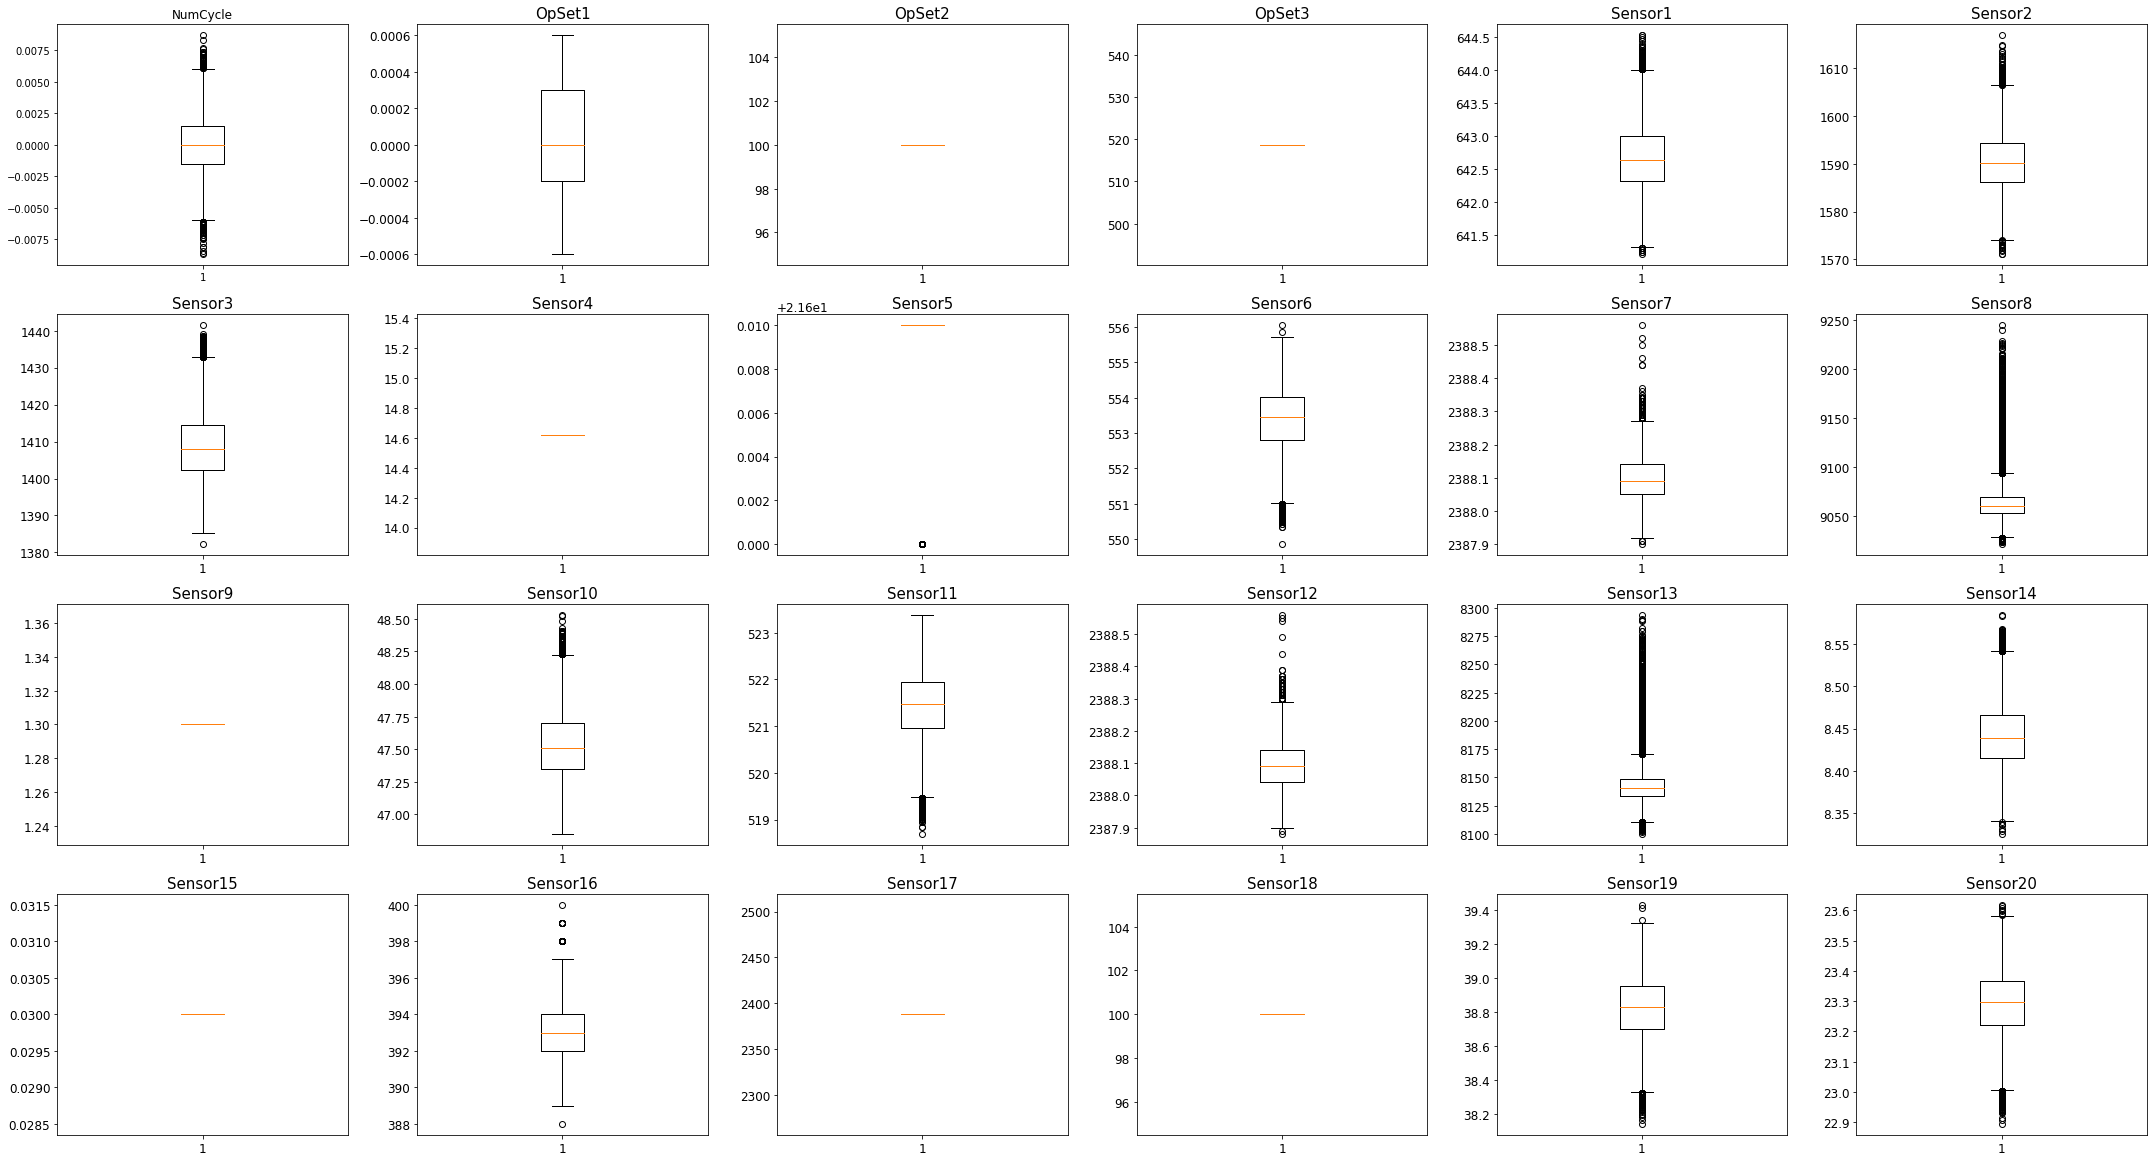

In [7]:
plt.figure(figsize = (30, 20))
for feat in np.arange(1, 25):       
  values = full_set_df.iloc[:, feat]
  plt.subplot(5, 6, feat)
  plt.boxplot(values)          
  plt.title(df.columns[feat])
  plt.rc('axes', titlesize = 15)
  plt.rc('xtick', labelsize = 12)
  plt.rc('ytick', labelsize = 12)

plt.tight_layout()
plt.show()

In [9]:
# Remove features that have two or fewer unique values
num_unique = full_set_df.nunique(axis=0).sort_values(ascending=False)
bool_unique = (num_unique <= 2)
remove_list_values = num_unique.iloc[bool_unique.values]
remove_list_1 = list(remove_list_values.keys())
print(remove_list_1)

['Sensor6', 'Sensor5', 'Sensor1', 'OpSet3', 'Sensor16', 'Sensor18', 'Sensor19', 'Sensor10']


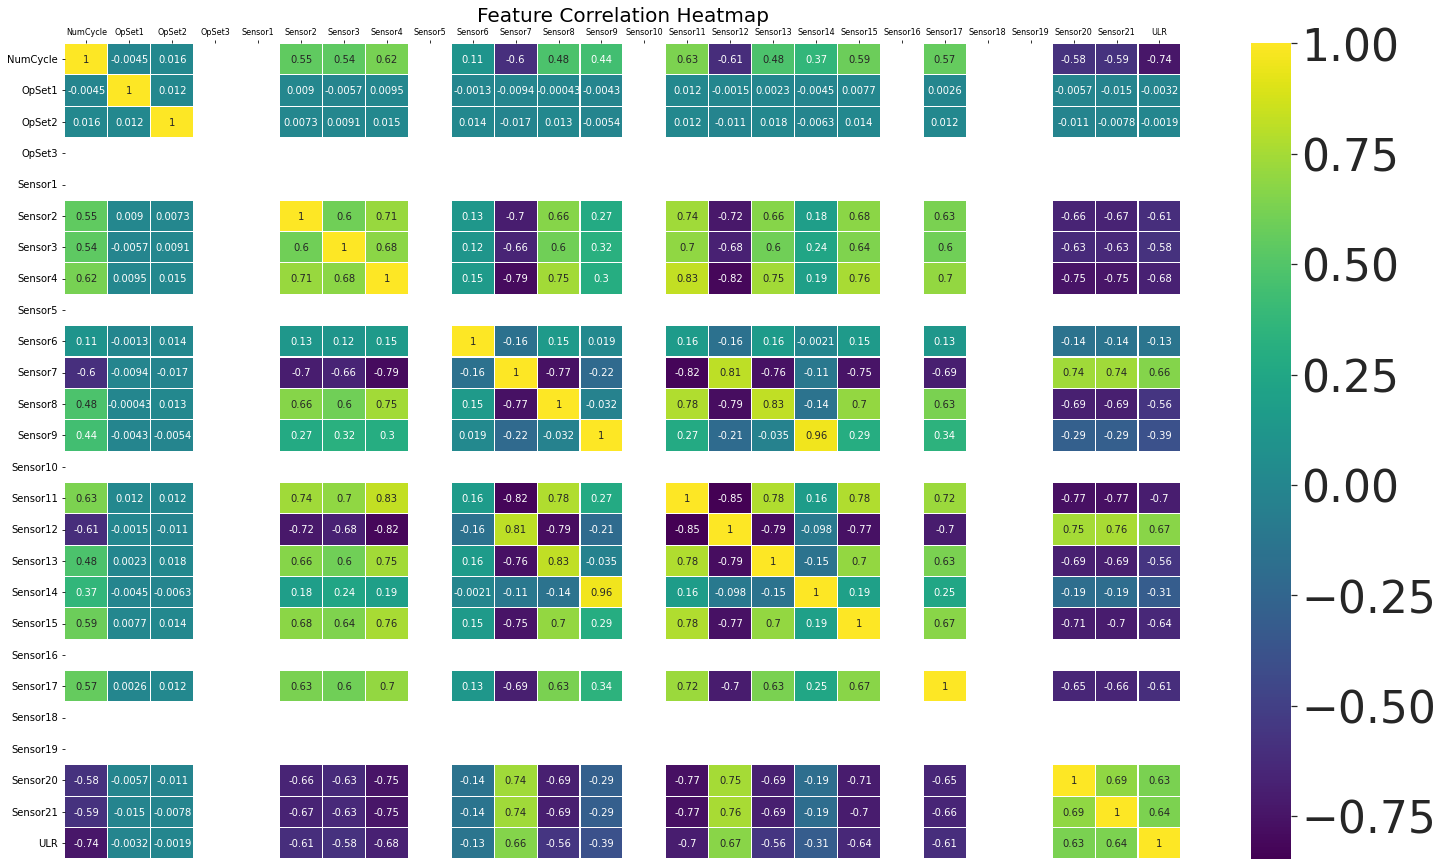

In [10]:
corr_mat_df = full_set_df.corr()

fig, ax = plt.subplots(figsize=(25, 15))

ax.set_title("Feature Correlation Heatmap", size = 20)
ax.set_xticklabels(labels = corr_mat_df.index, size = 8)
ax.set_yticklabels(labels = corr_mat_df.index, size = 10)
sns.set(font_scale=4, font="Times New Roman")
sns.heatmap(corr_mat_df, cmap="viridis", linewidths=0.1, annot=True, annot_kws={"size":10})
ax.xaxis.tick_top() 
ax.xaxis.set_label_position('top')

In [11]:
# Remove features that have less than 0.5 correlation with the target value
remove_list_2 = []
for feat in full_set_df.columns:
  corr_target = full_set_df[feat].corr(full_set_df['ULR'])
  if abs(corr_target) < 0.5:
    remove_list_2.append(feat)
        
remove_list_2

['OpSet1', 'OpSet2', 'Sensor5', 'Sensor6', 'Sensor9', 'Sensor14', 'Sensor16']

In [12]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, max_depth=10)

x = full_set_df.iloc[:, 0:-1]
y = full_set_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = False)

from sklearn.feature_selection import RFE
n_features_to_select = 10
rfe_model = RFE(regressor, n_features_to_select = n_features_to_select)
rfe_model.fit(X_train, y_train)

RFE(estimator=RandomForestRegressor(max_depth=10), n_features_to_select=10)

In [13]:
from operator import itemgetter
features = X_train.columns.to_list()
for x, y in (sorted(zip(rfe_model.ranking_ , features), key=itemgetter(0))):
  print(x, y)

1 NumCycle
1 Sensor2
1 Sensor4
1 Sensor7
1 Sensor9
1 Sensor11
1 Sensor12
1 Sensor14
1 Sensor15
1 Sensor21
2 Sensor8
3 Sensor3
4 Sensor13
5 Sensor20
6 OpSet1
7 OpSet2
8 Sensor17
9 Sensor6
10 Sensor10
11 Sensor5
12 Sensor19
13 Sensor1
14 Sensor16
15 OpSet3
16 Sensor18


In [14]:
remove_list_3 = ['Sensor17']

In [15]:
remove_list = list(set(remove_list_1 + remove_list_2 + remove_list_3))

In [16]:
best_features_df = full_set_df.drop(columns=remove_list)
best_features_df

,NumCycle,Sensor2,Sensor3,Sensor4,Sensor7,Sensor8,Sensor11,Sensor12,Sensor13,Sensor15,Sensor20,Sensor21,ULR
0,1,641.82,1589.70,1400.60,554.36,2388.06,47.47,521.66,2388.02,8.4195,39.06,23.4190,191
1,2,642.15,1591.82,1403.14,553.75,2388.04,47.49,522.28,2388.07,8.4318,39.00,23.4236,190
2,3,642.35,1587.99,1404.20,554.26,2388.08,47.27,522.42,2388.03,8.4178,38.95,23.3442,189
3,4,642.35,1582.79,1401.87,554.45,2388.11,47.13,522.86,2388.08,8.3682,38.88,23.3739,188
4,5,642.37,1582.85,1406.22,554.00,2388.06,47.28,522.19,2388.04,8.4294,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,196,643.49,1597.98,1428.63,551.43,2388.19,48.07,519.49,2388.26,8.4956,38.49,22.9735,4
20627,197,643.54,1604.50,1433.58,550.86,2388.23,48.04,519.68,2388.22,8.5139,38.30,23.1594,3
20628,198,643.42,1602.46,1428.18,550.94,2388.24,48.09,520.01,2388.24,8.5646,38.44,22.9333,2
20629,199,643.23,1605.26,1426.53,550.68,2388.25,48.39,519.67,2388.23,8.5389,38.29,23.0640,1


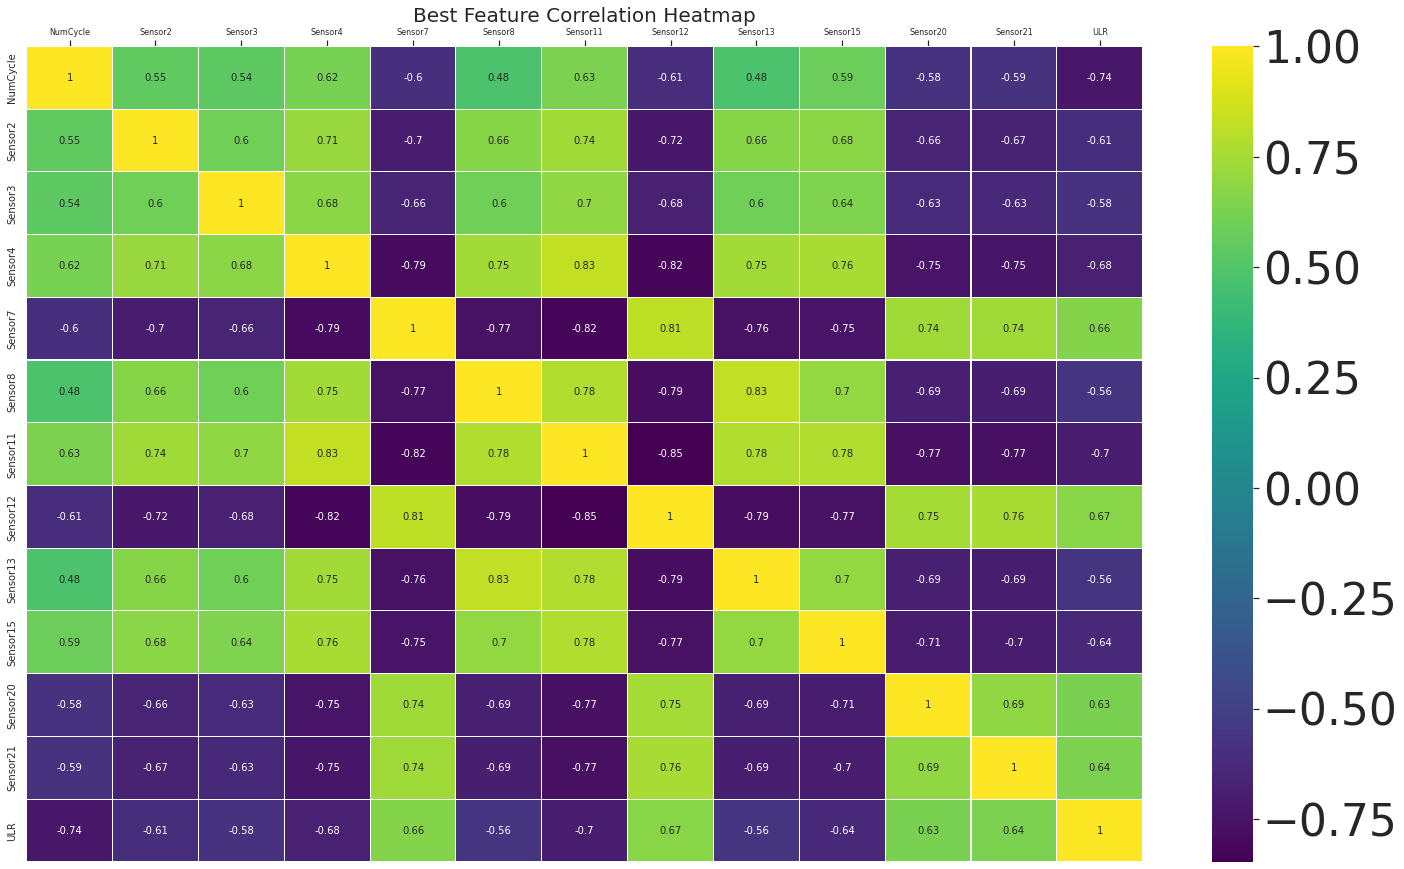

In [17]:
corr_mat_df = best_features_df.corr()

fig, ax = plt.subplots(figsize=(25, 15))

ax.set_title("Best Feature Correlation Heatmap", size=20)
ax.set_xticklabels(labels = corr_mat_df.index, size = 8)
ax.set_yticklabels(labels = corr_mat_df.index, size = 10)
sns.heatmap(corr_mat_df, cmap="viridis", linewidths=0.1, annot=True, annot_kws={"size":10})
ax.xaxis.tick_top() 
ax.xaxis.set_label_position('top')

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# the independent variables set
X = best_features_df.iloc[:, 0:12]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
  
print(vif_data)

     Feature           VIF
0   NumCycle  6.513350e+00
1    Sensor2  4.291499e+06
2    Sensor3  1.498305e+05
3    Sensor4  1.086511e+05
4    Sensor7  1.592626e+06
5    Sensor8  3.215919e+09
6   Sensor11  1.817717e+05
7   Sensor12  2.421135e+06
8   Sensor13  3.213067e+09
9   Sensor15  1.629969e+05
10  Sensor20  1.390630e+05
11  Sensor21  1.406646e+05


In [19]:
X = best_features_df.iloc[:, 0:12]
y = best_features_df.iloc[:, 12]

from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor()
model.fit(X,y)

ExtraTreesRegressor()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

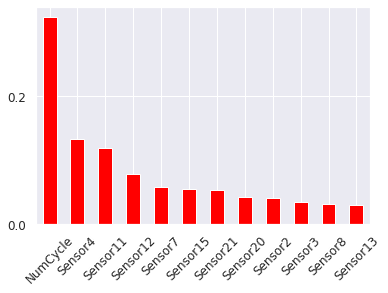

In [20]:
feat_importances = pd.Series(model.feature_importances_, index = X.columns)
feat_importances = feat_importances.sort_values()
feat_importances.nlargest(12).plot(kind='bar', fontsize = 12, color = 'red')
plt.xticks(rotation = 45)

In [40]:
'''
Forward feature selection
'''
from collections import defaultdict

final_features = list(feat_importances.keys())[::-1]
ranked_features_df = best_features_df[final_features]

num_features_used = []
testing_score_list = []
training_score_list = []   
result_dict = defaultdict(list)
num_features = ranked_features_df.shape[1]
for num_feats in range(1, num_features):
  num_features_used.append(num_feats)
  X = ranked_features_df.iloc[:, :num_feats]
  y = best_features_df.iloc[:, num_features]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

  regressor = RandomForestRegressor()
  regressor.fit(X_train, y_train)

  y_pred_test = regressor.predict(X_test)
  y_pred_train = regressor.predict(X_train)

  result_dict[num_feats] = [np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)), np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))]

score_results_df = pd.DataFrame.from_dict(result_dict, orient='index', columns = ['Test RMSE:', 'Train RMSE:']).T
score_results_df

,1,2,3,4,5,6,7,8,9,10,11
Test RMSE:,60.340806,55.101099,52.932712,52.159120,51.598841,51.262943,51.271068,51.182839,51.050616,50.888878,51.019481
Train RMSE:,39.329974,15.064059,13.567469,13.195735,12.978667,12.887183,12.837724,12.738187,12.697991,12.734082,12.664608


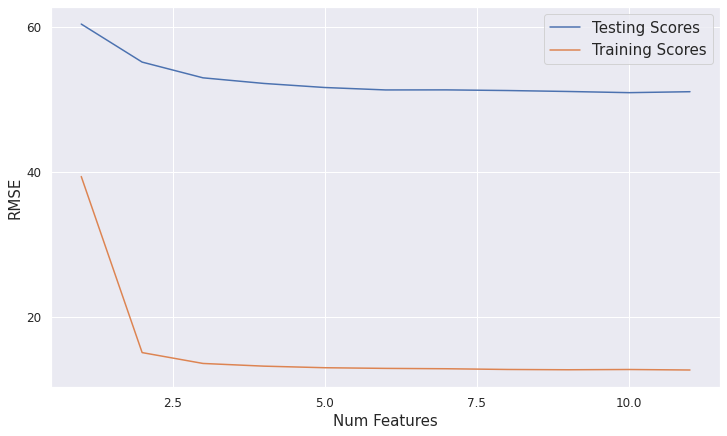

In [44]:
testing_score_list = list(score_results_df.loc['Test RMSE:'])
training_score_list = list(score_results_df.loc['Train RMSE:'])

plt.figure(figsize = (12, 7))

plt.plot(num_features_used, testing_score_list)
plt.plot(num_features_used, training_score_list)
plt.xlabel("Num Features", fontsize = 15)
plt.ylabel("RMSE", fontsize=15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(['Testing Scores','Training Scores'], prop={'size': 15})

plt.show()

# Transform/ Save CNN Model Data

In [48]:
Keep_Features = final_features
print(final_features)

['NumCycle', 'Sensor4', 'Sensor11', 'Sensor12', 'Sensor7', 'Sensor15', 'Sensor21', 'Sensor20', 'Sensor2', 'Sensor3', 'Sensor8', 'Sensor13']


In [69]:
set_num = 4
set_type = 'train'
model_type = 'regression'

In [70]:
uploaded = files.upload()
globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"] = pd.read_csv(f"{set_type}_FD00{set_num}.txt", sep = ' ', header = None)

Saving train_FD004.txt to train_FD004.txt


In [58]:
if set_type == 'test':
  uploaded = files.upload()
  globals()[f"Cycles_until_failure_00{set_num}_df"] = pd.read_csv(f"RUL_FD00{set_num}.txt", sep = ' ', header = None)

  globals()[f"Cycles_until_failure_00{set_num}_df"] = globals()[f"Cycles_until_failure_00{set_num}_df"].drop([1], axis = 1)
  globals()[f"Cycles_until_failure_00{set_num}_df"] = np.array(globals()[f"Cycles_until_failure_00{set_num}_df"])

In [71]:
globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"].drop([26,27], axis=1, inplace=True)
col_names = ['Engine_ID', 'NumCycle', 'OpSet1', 'OpSet2', 'OpSet3', 'Sensor1', 'Sensor2', 'Sensor3', 'Sensor4', 'Sensor5', 'Sensor6', 'Sensor7', 'Sensor8', 'Sensor9', 'Sensor10', 'Sensor11', 'Sensor12', 'Sensor13', 'Sensor14', 'Sensor15', 'Sensor16', 'Sensor17', 'Sensor18', 'Sensor19', 'Sensor20', 'Sensor21' ]
globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"].columns = col_names

globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]

,Engine_ID,NumCycle,OpSet1,OpSet2,OpSet3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor12,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,249,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,...,380.16,2388.73,8185.69,8.4541,0.03,372,2319,100.00,29.11,17.5234
61245,249,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,...,535.02,2388.46,8185.47,8.2221,0.03,396,2388,100.00,39.38,23.7151
61246,249,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,...,535.41,2388.48,8193.94,8.2525,0.03,395,2388,100.00,39.78,23.8270
61247,249,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,...,187.92,2388.83,8125.64,9.0515,0.02,337,2223,100.00,15.26,9.0774


In [72]:
#Append a 'Useful Life End' (ULE) in cycles to the dataset
if set_type == 'test':
  Cycles_provided = []
  for engine in range(1, len(globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]['Engine_ID'].unique())+1):
    Cycles_provided.append(len(globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"][globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]['Engine_ID'] == engine]))
  Cycles_provided = np.array(Cycles_provided).reshape([globals()[f"Cycles_until_failure_00{set_num}_df"].shape[0], 1])

  ULE = []
  for i in globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]['Engine_ID']:
    ULE.append(Cycles_provided[i-1] + globals()[f"Cycles_until_failure_00{set_num}_df"][i-1])

  ULE = np.array(ULE).reshape([len(ULE), 1])
  globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]['ULE'] = ULE

elif set_type == 'train':
  ULE = []
  for engine_num in globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]['Engine_ID']:
    ULE.append(len(globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"][globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]['Engine_ID'] == engine_num]))
  globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]['ULE'] = ULE

filter = []
if model_type == 'classification':
  # Calculate the 'Remaining Life Ratio' (RLR) from the ULE column
  globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]['RLR'] = globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]['NumCycle'].div(globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]['ULE'])

  '''
  Good = LRL <= 0.6
  Neutral = 0.6 < LRL <= 0.8
  Bad = LRL > 0.8
  '''

  conditions = [(globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]['RLR'] <= 0.6),
                (globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]['RLR'] > 0.6) & (globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]['RLR'] <= 0.8),
                (globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]['RLR'] > 0.8)]
  values = [0, 1, 2]

  #assign the condition column
  globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]['Condition'] = np.select(conditions, values)

  # Drop the RLR and Useful Life End columns
  globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"].drop(['RLR', 'ULE'], axis=1, inplace=True)

  filter = ['Engine_ID'] + Keep_Features + ['Condition']
  globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"] = globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"].filter(filter, axis=1)  

elif model_type == 'regression':
  # Append the 'Useful Life Remaining' (ULR) column to the dataset
  globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]['ULR'] = globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]['ULE'] - (globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]['NumCycle'])

  # Drop the Useful Life End columns
  globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"].drop(['ULE'], axis=1, inplace=True)

  filter = ['Engine_ID'] + Keep_Features + ['ULR']
  globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"] = globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"].filter(filter, axis=1)

In [73]:
globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"]

,Engine_ID,NumCycle,Sensor4,Sensor11,Sensor12,Sensor7,Sensor15,Sensor21,Sensor20,Sensor2,Sensor3,Sensor8,Sensor13,ULR
0,1,1,1112.93,41.69,129.78,137.36,9.3335,6.3670,10.62,549.68,1343.43,2211.86,2387.99,320
1,1,2,1237.50,43.94,312.59,332.10,9.1913,14.6552,24.37,606.07,1477.61,2323.66,2387.73,319
2,1,3,1117.05,41.66,129.62,138.18,9.4007,6.4213,10.48,548.95,1343.12,2211.92,2387.97,318
3,1,4,1118.03,41.68,129.80,137.98,9.3369,6.4176,10.54,548.70,1341.24,2211.88,2388.02,317
4,1,5,1033.59,36.48,164.11,174.82,10.8366,8.6754,14.03,536.10,1255.23,1915.22,2028.08,316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,249,251,1315.28,46.08,380.16,404.59,8.4541,17.5234,29.11,605.33,1516.36,2319.66,2388.73,4
61245,249,252,1426.77,48.04,535.02,567.59,8.2221,23.7151,39.38,643.42,1598.92,2388.47,2388.46,3
61246,249,253,1430.56,48.24,535.41,569.04,8.2525,23.8270,39.78,643.68,1607.72,2388.51,2388.48,2
61247,249,254,1148.18,42.53,187.92,199.93,9.0515,9.0774,15.26,555.77,1381.29,2223.78,2388.83,1


In [74]:
globals()[f"NASA_Engine_{set_type}_Data_00{set_num}_df"].to_csv(f"Nasa_{set_type}_{set_num}.csv", index = None) 
files.download(f"Nasa_{set_type}_{set_num}.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Load CNN Model Data

In [242]:
set_num = 4
set_type = 'train'

In [243]:
uploaded = files.upload()
globals()[f"{set_type}_df_{set_num}"] = pd.read_csv(f"Nasa_{set_type}_{set_num}.csv")

Saving Nasa_train_4.csv to Nasa_train_4 (2).csv


In [246]:
'''
Features to keep in the final model based on feature selection
'''
final_model_feature_list = ['Engine_ID', 'NumCycle', 'Sensor4', 'Sensor11', 'Sensor12', 'ULR']
train_df_1 = train_df_1.filter(items = final_model_feature_list)
train_df_2 = train_df_2.filter(items = final_model_feature_list)
train_df_3 = train_df_3.filter(items = final_model_feature_list)
train_df_4 = train_df_4.filter(items = final_model_feature_list)

In [247]:
'''
Load all 4 sets in before running this function
'''
if set_type == 'train':
  globals()[f"{set_type}_df"] = pd.concat([train_df_1, train_df_2, train_df_3, train_df_4], ignore_index=True)
  
elif set_type == 'test':
  globals()[f"{set_type}_df"] = pd.concat([test_df_1, test_df_2, test_df_3, test_df_4], ignore_index=True)

globals()[f"{set_type}_model_data_df"] = globals()[f"{set_type}_df"].drop('Engine_ID', axis=1)

In [248]:
globals()[f"{set_type}_model_data_df"]

,NumCycle,Sensor4,Sensor11,Sensor12,ULR
0,1,1400.60,47.47,521.66,191
1,2,1403.14,47.49,522.28,190
2,3,1404.20,47.27,522.42,189
3,4,1401.87,47.13,522.86,188
4,5,1406.22,47.28,522.19,187
...,...,...,...,...,...
160354,251,1315.28,46.08,380.16,4
160355,252,1426.77,48.04,535.02,3
160356,253,1430.56,48.24,535.41,2
160357,254,1148.18,42.53,187.92,1


# Process CNN Data

In [323]:
def Convert_Data(set_type, set_num, engine_num, window_len, sample_rate, batch_len):    

  var = globals()[f"{set_type}_df_{set_num}"][globals()[f"{set_type}_df_{set_num}"]['Engine_ID'] == engine_num]
  var = var.drop(columns = ['Engine_ID'])  

  scaler = MinMaxScaler()
  globals()[f"model_{set_type}_dataset_{set_num}_engine_{engine_num}"] = scaler.fit_transform(var)
  print(f'Shape of model_{set_type}_dataset_{set_num}_engine_{engine_num}: {globals()[f"model_{set_type}_dataset_{set_num}_engine_{engine_num}"].shape}')  

  feature_data = globals()[f"model_{set_type}_dataset_{set_num}_engine_{engine_num}"][:,0:-1]
  target_data = globals()[f"model_{set_type}_dataset_{set_num}_engine_{engine_num}"][:,-1]  

  time_series_data = TimeseriesGenerator(data = feature_data, targets = target_data, length = window_len, sampling_rate = sample_rate, batch_size = batch_len)

  X = list()
  y = list()
  for i in range(len(time_series_data)):
      x_temp, y_temp = time_series_data[i]
      X.append(x_temp.reshape(x_temp.shape[1], x_temp.shape[2], 1))
      y.append(y_temp)

  X = np.array(X)  
  y = np.array(y)  

  return(X, y, scaler, feature_data)

# Create CNN Model

In [278]:
window_len = 30   
num_features = 4 

model = Sequential()
model.add(Conv2D(filters=128, kernel_size=4, activation='relu', padding='same', input_shape=(window_len, num_features, 1)))
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=4, activation='relu', padding='same',))
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(filters=32, kernel_size=4, activation='relu', padding='same',))
model.add(Conv2D(filters=16, kernel_size=4, activation='relu', padding='same',))
model.add(Flatten())
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Train CNN Model

In [279]:
set_num = 1
set_type = 'train'
sample_rate = 1
batch_len = 1

for set_number in range(1, 5):
  for engine_num in range(1, 66):    
    X, y, scaler, features = Convert_Data(set_type, set_number, engine_num, window_len, sample_rate, batch_len) 

    model.fit(X, y, steps_per_epoch=5, epochs=15, shuffle=False, verbose=0)

Shape of model_train_dataset_1_engine_1: (192, 5)
Shape of model_train_dataset_1_engine_2: (287, 5)
Shape of model_train_dataset_1_engine_3: (179, 5)
Shape of model_train_dataset_1_engine_4: (189, 5)
Shape of model_train_dataset_1_engine_5: (269, 5)
Shape of model_train_dataset_1_engine_6: (188, 5)
Shape of model_train_dataset_1_engine_7: (259, 5)
Shape of model_train_dataset_1_engine_8: (150, 5)
Shape of model_train_dataset_1_engine_9: (201, 5)
Shape of model_train_dataset_1_engine_10: (222, 5)
Shape of model_train_dataset_1_engine_11: (240, 5)
Shape of model_train_dataset_1_engine_12: (170, 5)
Shape of model_train_dataset_1_engine_13: (163, 5)
Shape of model_train_dataset_1_engine_14: (180, 5)
Shape of model_train_dataset_1_engine_15: (207, 5)
Shape of model_train_dataset_1_engine_16: (209, 5)
Shape of model_train_dataset_1_engine_17: (276, 5)
Shape of model_train_dataset_1_engine_18: (195, 5)
Shape of model_train_dataset_1_engine_19: (158, 5)
Shape of model_train_dataset_1_engine_20

# Save CNN Model

In [289]:
model.save("NASA_CNN_Train_02.h5")

# Load CNN Model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from keras.models import load_model
 
# load model
model = load_model('NASA_CNN_Train_02.h5')

# Evaluate CNN Model (Training Set)

In [389]:
set_tupe = 'train'
set_num = 3
engine_num = 30
window_len = 30
sample_rate = 1
batch_len = 1

X, y, scaler, features = Convert_Data(set_type, set_num, engine_num, window_len, sample_rate, batch_len) 

Shape of model_train_dataset_3_engine_30: (218, 5)


In [390]:
predicted_values_df = pd.concat([pd.DataFrame(features[window_len:]), pd.DataFrame(model.predict(X))], axis=1)
predicted_values_df = scaler.inverse_transform(predicted_values_df)
predicted_values_df = pd.DataFrame(predicted_values_df, columns = final_model_feature_list[1:])
predicted_values_df

6/6 [==============================] - 0s 13ms/step


,NumCycle,Sensor4,Sensor11,Sensor12,ULR
0,31.0,1399.11,47.14,521.91,194.117834
1,32.0,1400.96,47.27,522.09,192.587459
2,33.0,1396.67,47.20,522.10,191.099520
3,34.0,1400.08,47.34,522.99,189.681194
4,35.0,1396.90,47.40,522.37,188.261264
...,...,...,...,...,...
183,214.0,1424.90,48.04,520.89,10.888146
184,215.0,1428.07,48.06,520.05,10.022726
185,216.0,1425.67,48.18,520.17,9.067530
186,217.0,1432.16,47.90,520.34,7.686955


In [391]:
df = globals()[f"{set_type}_df_{set_num}"][globals()[f"{set_type}_df_{set_num}"]['Engine_ID'] == engine_num]
actual_values_df = df.drop(columns=['Engine_ID'])
actual_values_df

,NumCycle,Sensor4,Sensor11,Sensor12,ULR
7987,1,1397.70,47.24,521.94,217
7988,2,1394.95,47.23,522.53,216
7989,3,1400.51,47.12,522.06,215
7990,4,1398.68,47.24,521.99,214
7991,5,1392.92,47.35,522.50,213
...,...,...,...,...,...
8200,214,1424.90,48.04,520.89,4
8201,215,1428.07,48.06,520.05,3
8202,216,1425.67,48.18,520.17,2
8203,217,1432.16,47.90,520.34,1


In [392]:
print('Sample Training RMSE Score:', np.sqrt(metrics.mean_squared_error(actual_values_df['ULR'][window_len:], predicted_values_df['ULR'])))

Sample Training RMSE Score: 5.952420410506891


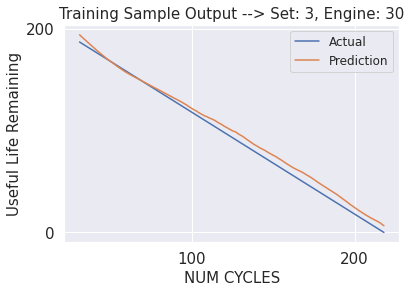

In [393]:
plt.plot(actual_values_df['NumCycle'][window_len:], actual_values_df['ULR'][window_len:])
plt.plot(predicted_values_df['NumCycle'], predicted_values_df['ULR'])
plt.ylabel('Useful Life Remaining', fontsize=15)
plt.xlabel('NUM CYCLES', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Training Sample Output --> Set: {}, Engine: {}'.format(set_num, engine_num), fontsize=15)
plt.legend(['Actual', 'Prediction'], loc='upper right', fontsize=12)
plt.show()

# Evaluate CNN Model (Testing Data)

In [394]:
set_tupe = 'train'
set_num = 4
engine_num = 90
window_len = 30
sample_rate = 1
batch_len = 1

X, y, scaler, features = Convert_Data(set_type, set_num, engine_num, window_len, sample_rate, batch_len) 

Shape of model_train_dataset_4_engine_90: (212, 5)


In [395]:
predicted_values_df = pd.concat([pd.DataFrame(features[window_len:]), pd.DataFrame(model.predict(X))], axis=1)
predicted_values_df = scaler.inverse_transform(predicted_values_df)
predicted_values_df = pd.DataFrame(predicted_values_df, columns = final_model_feature_list[1:])

df = globals()[f"{set_type}_df_{set_num}"][globals()[f"{set_type}_df_{set_num}"]['Engine_ID'] == engine_num]
actual_values_df = df.drop(columns=['Engine_ID'])

6/6 [==============================] - 0s 12ms/step


In [396]:
print('Sample Testing RMSE Score:', np.sqrt(metrics.mean_squared_error(actual_values_df['ULR'][window_len:], predicted_values_df['ULR'])))

Sample Testing RMSE Score: 5.610246945650745


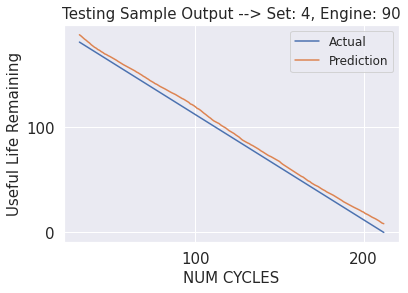

In [397]:
plt.plot(actual_values_df['NumCycle'][window_len:], actual_values_df['ULR'][window_len:])
plt.plot(predicted_values_df['NumCycle'], predicted_values_df['ULR'])
plt.ylabel('Useful Life Remaining', fontsize=15)
plt.xlabel('NUM CYCLES', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Testing Sample Output --> Set: {}, Engine: {}'.format(set_num, engine_num), fontsize=15)
plt.legend(['Actual', 'Prediction'], loc='upper right', fontsize=12)
plt.show()

In [364]:
set_type = 'train'
window_len = 30
sample_rate = 1
batch_len = 1

result_dict = defaultdict(list)
for set_num in range(1, 5):
  for engine_num in range(76, 101):
    X, y, scaler, features = Convert_Data(set_type, set_num, engine_num, window_len, sample_rate, batch_len) 

    predicted_values_df = pd.concat([pd.DataFrame(features[window_len:]), pd.DataFrame(model.predict(X))], axis=1)
    predicted_values_df = scaler.inverse_transform(predicted_values_df)
    predicted_values_df = pd.DataFrame(predicted_values_df, columns = final_model_feature_list[1:])
    
    df = globals()[f"{set_type}_df_{set_num}"][globals()[f"{set_type}_df_{set_num}"]['Engine_ID'] == engine_num]
    actual_values_df = df.drop(columns=['Engine_ID'])

    key_str = str(set_num) + ' - ' + str(engine_num)
    result_dict[key_str] = [np.sqrt(metrics.mean_squared_error(actual_values_df['ULR'][window_len:], predicted_values_df['ULR']))]

Shape of model_train_dataset_1_engine_76: (210, 5)
6/6 [==============================] - 0s 11ms/step
Shape of model_train_dataset_1_engine_77: (154, 5)
4/4 [==============================] - 0s 12ms/step
Shape of model_train_dataset_1_engine_78: (231, 5)
7/7 [==============================] - 0s 12ms/step
Shape of model_train_dataset_1_engine_79: (199, 5)
6/6 [==============================] - 0s 11ms/step
Shape of model_train_dataset_1_engine_80: (185, 5)
5/5 [==============================] - 0s 17ms/step
Shape of model_train_dataset_1_engine_81: (240, 5)
7/7 [==============================] - 0s 11ms/step
Shape of model_train_dataset_1_engine_82: (214, 5)
6/6 [==============================] - 0s 11ms/step
Shape of model_train_dataset_1_engine_83: (293, 5)
9/9 [==============================] - 0s 11ms/step
Shape of model_train_dataset_1_engine_84: (267, 5)
8/8 [==============================] - 0s 11ms/step
Shape of model_train_dataset_1_engine_85: (188, 5)
5/5 [=================

In [360]:
test_score_results_df = pd.DataFrame.from_dict(result_dict, orient='index', columns = ['RMSE Test Scores:'])
test_score_results_df                                                                                       

,RMSE Test Scores:
1 - 76,5.395191
1 - 77,8.328938
1 - 78,7.004821
1 - 79,5.854438
1 - 80,7.865814
...,...
4 - 96,3.511065
4 - 97,4.887544
4 - 98,5.055379
4 - 99,7.902184


# Conclusion

In [399]:
avg_rmse_score = test_score_results_df['RMSE Test Scores:'].mean()
print(f'The average RMSE on the entire test set for this convoutional neural network model is: {round(avg_rmse_score, 2)}')

The average RMSE on the entire test set for this convoutional neural network model is: 6.19


[Link to the Dataset](https://www.kaggle.com/datasets/behrad3d/nasa-cmaps)


I just wanted to get some experience predicting 'remaining useful life' with sample aircraft data. I was able to achieve an aveage RMSE of 6.19 using a convolutional neural network.

I did not get into as much depth with exploratory data analysis, feature selection and hyperparameter tuning as I would have under normal circumstances although I thought this exercise gave me a much better insight into the type of work I might be exposed to if I were to be hired into the maintenance, repair and overhaul division at GE Aviation. 